In [2]:
import pandas as pd

In [12]:
df = pd.read_csv('combined_cleaned_file.csv')
df = df.drop(columns=['id'])
df.to_csv('combined_cleaned_file.txt', sep='\t', index=False)


In [17]:
import json
import os
import re # Import thư viện regular expression

def normalize_text(text):
    """
    Hàm làm sạch text:
    1. Thay thế các loại whitespace (newline, tab,...) bằng space thường.
    2. Gộp nhiều space liên tiếp thành một.
    3. Loại bỏ space thừa ở đầu/cuối.
    """
    if not isinstance(text, str):
        return "" # Trả về chuỗi rỗng nếu không phải string

    # Bước 1: Thay thế các loại whitespace bằng space thường
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

    # Bước 2: Thay thế nhiều khoảng trắng liên tiếp bằng một khoảng trắng duy nhất
    # Dùng ' {2,}' để chỉ khớp với 2 hoặc nhiều dấu cách liền nhau
    text = re.sub(r' {2,}', ' ', text)

    # Bước 3: Loại bỏ khoảng trắng ở đầu và cuối chuỗi
    text = text.strip()
    return text

def clean_aspect_text(text):
    """
    Hàm làm sạch aspect_text: chuẩn hóa và loại bỏ dấu nháy kép bao quanh.
    Gọi normalize_text nhiều lần để đảm bảo tính nhất quán sau các bước xử lý.
    """
    if not isinstance(text, str):
        return ""
    # Bước 1: Chuẩn hóa text cơ bản lần đầu
    text = normalize_text(text)

    # Bước 2: Xử lý dấu nháy bao quanh (nếu có)
    cleaned_internally = False
    if text.startswith('"""') and text.endswith('"""'):
        text = text[3:-3].strip() # Bỏ dấu nháy và strip khoảng trắng lộ ra
        cleaned_internally = True
    elif text.startswith('"') and text.endswith('"'):
        text = text[1:-1].strip() # Bỏ dấu nháy và strip khoảng trắng lộ ra
        cleaned_internally = True

    # Bước 3: Nếu đã bỏ dấu nháy, chuẩn hóa lại bên trong lần nữa
    if cleaned_internally:
        text = normalize_text(text)

    # Bước 4: Trả về kết quả đã chuẩn hóa cuối cùng
    # (Gọi normalize_text lần cuối để đảm bảo chắc chắn, dù có thể thừa)
    return normalize_text(text)

# --- Hàm convert_to_semeval_json giữ nguyên phần còn lại ---
# (Copy lại toàn bộ hàm convert_to_semeval_json từ phiên bản V2
#  vì chỉ cần thay đổi 2 hàm helper normalize_text và clean_aspect_text)

def convert_to_semeval_json(input_filepath, output_filepath):
    """
    Chuyển đổi file text chứa dữ liệu ABSA sang định dạng JSON giống SemEval.
    (Phiên bản cải thiện xử lý khoảng trắng và dấu nháy - v3)

    Args:
        input_filepath (str): Đường dẫn đến file text đầu vào.
        output_filepath (str): Đường dẫn để lưu file JSON đầu ra.
    """
    sentences_data = {}
    found_count = 0
    not_found_count = 0
    found_in_sc_count = 0

    try:
        with open(input_filepath, 'r', encoding='utf-8') as f:
            header = next(f).strip().split('\t')
            print(f"Đã đọc header: {header}")

            for line_num, line in enumerate(f, 1):
                # Xử lý line đọc vào (giữ nguyên từ v2)
                line = line.replace('\n', ' ').replace('\r', '')
                parts = line.strip().split('\t')

                if len(parts) != 6:
                    print(f"Cảnh báo: Dòng {line_num} không có đủ 6 cột, bỏ qua: {line.strip()}")
                    continue

                review_orig, sentence_component_orig, aspect_text_orig, aspect_category, sentiment_text, sentiment = parts

                # --- Sử dụng hàm chuẩn hóa MỚI ---
                review = normalize_text(review_orig)
                cleaned_aspect_text = clean_aspect_text(aspect_text_orig)
                sentence_component = normalize_text(sentence_component_orig)
                # --- Hết phần sử dụng hàm chuẩn hóa MỚI ---

                if not cleaned_aspect_text:
                    # Kiểm tra aspect_text rỗng sau khi làm sạch (giữ nguyên từ v2)
                    if aspect_text_orig.strip(): # Chỉ cảnh báo nếu gốc không phải là rỗng/khoảng trắng
                         print(f"Cảnh báo: aspect_text ('{aspect_text_orig}') trở thành rỗng sau khi làm sạch ở dòng {line_num}. Bỏ qua.")
                    # Không cần in gì nếu gốc đã là khoảng trắng
                    continue


                sentiment = sentiment.lower()
                if sentiment not in ["positive", "negative", "neutral"]:
                     print(f"Cảnh báo: Sentiment không xác định '{sentiment}' ở dòng {line_num}, giữ nguyên.")


                start_index = -1
                end_index = -1
                term_to_store = aspect_text_orig # Mặc định lưu text gốc nếu không tìm thấy

                # Tìm vị trí 'from' và 'to' (logic giữ nguyên từ v2)
                start_index = review.find(cleaned_aspect_text)

                if start_index != -1:
                    end_index = start_index + len(cleaned_aspect_text)
                    term_to_store = cleaned_aspect_text
                    found_count += 1
                else:
                    # Không tìm thấy trong review, thử tìm trong sentence_component
                    # (In thông báo tìm kiếm) - Chỉ in nếu cleaned_aspect_text có nội dung
                    if cleaned_aspect_text:
                        print(f"Thông tin: Không tìm thấy '{cleaned_aspect_text}' trong review (dòng {line_num}). Thử tìm trong sentence_component.")

                    start_index_in_sc = sentence_component.find(cleaned_aspect_text)

                    if start_index_in_sc != -1:
                         if cleaned_aspect_text: # Chỉ in nếu tìm thấy text có nội dung
                              print(f"Thông tin: Tìm thấy '{cleaned_aspect_text}' trong sentence_component (dòng {line_num}).")
                         start_index_sc_in_review = review.find(sentence_component)

                         if start_index_sc_in_review != -1:
                             start_index = start_index_sc_in_review + start_index_in_sc
                             end_index = start_index + len(cleaned_aspect_text)
                             term_to_store = cleaned_aspect_text
                             found_in_sc_count += 1
                             print(f"Thông tin: Đã tính index tương đối với review cho dòng {line_num}.")
                         else:
                             if sentence_component: # Chỉ in lỗi nếu sentence_component không rỗng
                                 print(f"Lỗi: Tìm thấy aspect_text trong sentence_component, nhưng không tìm thấy sentence_component '{sentence_component[:50]}...' trong review ở dòng {line_num}. Gán from/to = -1.")
                             else: # SC rỗng thì không thể tìm thấy là đúng
                                  print(f"Thông tin: sentence_component rỗng ở dòng {line_num}, không thể tìm trong đó. Gán from/to = -1.")
                             not_found_count += 1
                             start_index = -1
                             end_index = -1
                    else:
                         # Không tìm thấy ở đâu cả
                         if cleaned_aspect_text: # Chỉ in lỗi nếu text tìm kiếm không rỗng
                             print(f"Lỗi: Không tìm thấy aspect_text '{cleaned_aspect_text}' (đã làm sạch) trong cả review và sentence_component ở dòng {line_num}. Gán from/to = -1.")
                         # Không cần in lỗi nếu cleaned_aspect_text rỗng
                         not_found_count += 1
                         start_index = -1
                         end_index = -1

                # Lưu thông tin aspect (logic giữ nguyên từ v2)
                aspect_info = {
                    "term": term_to_store,
                    "category": normalize_text(aspect_category),
                    "polarity": sentiment,
                    "from": str(start_index),
                    "to": str(end_index)
                }

                # Nhóm các aspect theo câu (logic giữ nguyên từ v2)
                review_key = review_orig.strip()
                if review_key not in sentences_data:
                    sentences_data[review_key] = {
                        "text": review_key,
                        "aspects": []
                    }

                if start_index != -1:
                     sentences_data[review_key]["aspects"].append(aspect_info)
                else:
                     if term_to_store.strip(): # Chỉ debug nếu term gốc không phải là khoảng trắng
                         print(f"Debug: Aspect không được thêm vào JSON (dòng {line_num}): {aspect_info}")


    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file đầu vào tại '{input_filepath}'")
        return
    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình đọc file: {e}")
        import traceback
        traceback.print_exc()
        return

    # Chuyển đổi và ghi file JSON (logic giữ nguyên từ v2)
    output_list = list(sentences_data.values())
    try:
        with open(output_filepath, 'w', encoding='utf-8') as f:
            json.dump({"sentences": {"sentence": output_list}}, f, ensure_ascii=False, indent=4)
        print("-" * 20)
        print(f"Đã chuyển đổi thành công và lưu vào file: {output_filepath}")
        print(f"Thống kê tìm kiếm aspect_text:")
        print(f"- Tìm thấy trực tiếp trong Review: {found_count}")
        print(f"- Tìm thấy trong Sentence Component (tính được index): {found_in_sc_count}")
        print(f"- Không tìm thấy / Lỗi index / Bị rỗng: {not_found_count}") # Đổi tên cho rõ hơn
        total_processed = found_count + found_in_sc_count + not_found_count
        print(f"- Tổng số aspect đã xử lý (dòng): {total_processed}") # Tổng số dòng aspect đã đọc và xử lý
        # Tính tổng số aspect thực sự được thêm vào JSON cuối cùng
        final_aspect_count = sum(len(s['aspects']) for s in output_list)
        print(f"- Tổng số aspect được thêm vào JSON: {final_aspect_count}")
        print("-" * 20)

    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình ghi file JSON: {e}")


# --- Sử dụng hàm ---
input_file = 'combined_cleaned_file.txt'
# Đổi tên file output khác để không ghi đè lên file V2
output_file = 'output_semeval_format_v3.json'

if os.path.exists(input_file):
    convert_to_semeval_json(input_file, output_file)
else:
    print(f"Lỗi: File '{input_file}' không tồn tại trong thư mục hiện tại.")

Đã đọc header: ['Review', 'Sentence Component', 'aspect_text', 'aspect', 'sentiment_text', 'sentiment']
Thông tin: Không tìm thấy '\ngiảng viên dạy' trong review (dòng 16796). Thử tìm trong sentence_component.
Lỗi: Không tìm thấy aspect_text '\ngiảng viên dạy' (đã làm sạch) trong cả review và sentence_component ở dòng 16796. Gán from/to = -1.
Debug: Aspect không được thêm vào JSON (dòng 16796): {'term': '\\ngiảng viên dạy ', 'category': 'Teaching quality', 'polarity': 'negative', 'from': '-1', 'to': '-1'}
--------------------
Đã chuyển đổi thành công và lưu vào file: output_semeval_format_v3.json
Thống kê tìm kiếm aspect_text:
- Tìm thấy trực tiếp trong Review: 20777
- Tìm thấy trong Sentence Component (tính được index): 0
- Không tìm thấy / Lỗi index / Bị rỗng: 1
- Tổng số aspect đã xử lý (dòng): 20778
- Tổng số aspect được thêm vào JSON: 20777
--------------------


In [14]:
import json
import os

def format_to_simplified_visd4sa(input_filepath, output_filepath):
    """
    Chuyển đổi file text sang định dạng JSON Lines giống UIT-ViSD4SA,
    chỉ giữ lại text và danh sách các cặp [CATEGORY#POLARITY].

    Args:
        input_filepath (str): Đường dẫn đến file text đầu vào (tab-separated).
        output_filepath (str): Đường dẫn để lưu file JSON Lines đầu ra.
    """
    sentences_data = {} # Dictionary để nhóm các cặp Category#Polarity theo câu

    try:
        with open(input_filepath, 'r', encoding='utf-8') as infile:
            # Bỏ qua dòng header
            header = next(infile).strip().split('\t')
            print(f"Đã đọc header: {header}")

            for line_num, line in enumerate(infile, 1):
                parts = line.strip().split('\t')

                # Kiểm tra số lượng cột (cần ít nhất cột Review, aspect, sentiment)
                if len(parts) != 6:
                    print(f"Cảnh báo: Dòng {line_num} không có đủ 6 cột, bỏ qua: {line.strip()}")
                    continue

                # Lấy các cột cần thiết
                # Column 0: Review (text gốc)
                # Column 3: aspect (category)
                # Column 5: sentiment (polarity)
                review_text = parts[0].strip()
                category = parts[3].strip()
                polarity = parts[5].strip()

                # Chuẩn hóa polarity sang uppercase giống UIT-ViSD4SA
                # và xử lý các trường hợp có thể có
                if polarity.lower() == 'positive':
                    polarity_formatted = 'POSITIVE'
                elif polarity.lower() == 'negative':
                    polarity_formatted = 'NEGATIVE'
                elif polarity.lower() == 'neutral':
                    polarity_formatted = 'NEUTRAL'
                else:
                    print(f"Cảnh báo: Polarity không xác định '{polarity}' ở dòng {line_num}. Sử dụng giá trị gốc.")
                    # Quyết định cách xử lý: bỏ qua, dùng giá trị gốc, hoặc gán mặc định
                    # Ở đây ta dùng giá trị gốc và viết hoa
                    polarity_formatted = polarity.upper()

                # Tạo chuỗi "CATEGORY#POLARITY"
                label_string = f"{category}#{polarity_formatted}"

                # Thêm vào dictionary, sử dụng set để tránh trùng lặp nhãn cho cùng một câu
                if review_text not in sentences_data:
                    sentences_data[review_text] = set() # Dùng set để tự động loại bỏ trùng lặp
                sentences_data[review_text].add(label_string)

    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file đầu vào tại '{input_filepath}'")
        return
    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình đọc file input: {e}")
        return

    # Ghi ra file JSON Lines
    try:
        with open(output_filepath, 'w', encoding='utf-8') as outfile:
            count = 0
            for text, labels_set in sentences_data.items():
                # Tạo đối tượng dictionary cho dòng JSON
                json_object = {
                    "text": text,
                    "labels": sorted(list(labels_set)) # Chuyển set thành list, sắp xếp để nhất quán (tùy chọn)
                }
                # Chuyển dictionary thành chuỗi JSON
                json_line = json.dumps(json_object, ensure_ascii=False)
                # Ghi chuỗi JSON vào file, theo sau là ký tự xuống dòng
                outfile.write(json_line + '\n')
                count += 1
        print(f"Đã chuyển đổi thành công và lưu {count} dòng vào file: {output_filepath}")

    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình ghi file JSON Lines: {e}")

# --- Sử dụng hàm ---
input_file = 'combined_cleaned_file.txt' # File input của bạn
output_file = 'output_simplified_visd4sa_format.jsonl' # File output định dạng JSON Lines (.jsonl)

# Kiểm tra xem file input có tồn tại không
if os.path.exists(input_file):
    format_to_simplified_visd4sa(input_file, output_file)
else:
    print(f"Lỗi: File '{input_file}' không tồn tại trong thư mục hiện tại.")

Đã đọc header: ['Review', 'Sentence Component', 'aspect_text', 'aspect', 'sentiment_text', 'sentiment']
Đã chuyển đổi thành công và lưu 15519 dòng vào file: output_simplified_visd4sa_format.jsonl


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Đọc dữ liệu từ file CSV
df = pd.read_csv('combined_cleaned_file.csv')

# Ánh xạ aspect -> số nguyên
aspect_mapping = {
    "Course information": 0,
    "General review": 1,
    "Learning environment": 2,
    "Organization and management": 3,
    "Support from lecturers": 4,
    "Teaching quality": 5,
    "Test and evaluation": 6,
    "Workload": 7
}

# Ánh xạ sentiment -> số nguyên
sentiment_mapping = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

# Thay thế aspect và sentiment bằng số tương ứng
df["aspect_encoded"] = df["aspect"].map(aspect_mapping)
df["sentiment_encoded"] = df["sentiment"].map(sentiment_mapping)

df = df.drop(columns=['id'])
df = df.rename({'Sentence Component': "text"})
# Chia lần 1: train (70%) và temp (30%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Chia lần 2: temp thành test (20%) và val (10%)
test_df, val_df = train_test_split(temp_df, test_size=1/3, random_state=42)  # 1/3 của 30% là 10%

# Kiểm tra kích thước
print(f'Train: {len(train_df)}')
print(f'Test: {len(test_df)}')
print(f'Validation: {len(val_df)}')

# Lưu lại nếu cần
train_df.to_csv('uit_train_absa.csv', index=False)
test_df.to_csv('uit_test_absa.csv', index=False)
val_df.to_csv('uit_val_absa.csv', index=False)


Train: 14545
Test: 4156
Validation: 2078


In [ ]:
#Chuyển đổi sang ASCA format

import json
import os
from collections import defaultdict # Sử dụng defaultdict để nhóm dễ dàng hơn

def format_for_asca_json(input_filepath, output_filepath):
    """
    Chuyển đổi file text sang định dạng JSON cho tác vụ ASCA.

    Args:
        input_filepath (str): Đường dẫn đến file text đầu vào (tab-separated).
        output_filepath (str): Đường dẫn để lưu file JSON đầu ra.
    """
    # Sử dụng defaultdict(set) để tự động xử lý câu mới và tránh trùng lặp cặp (category, polarity)
    sentences_data = defaultdict(set)

    try:
        with open(input_filepath, 'r', encoding='utf-8') as infile:
            header = next(infile).strip().split('\t')
            print(f"Đã đọc header: {header}")

            for line_num, line in enumerate(infile, 1):
                # Loại bỏ ký tự xuống dòng trong chính dòng đọc vào
                line = line.replace('\n', ' ').replace('\r', '')
                parts = line.strip().split('\t')

                if len(parts) != 6:
                    print(f"Cảnh báo: Dòng {line_num} không có đủ 6 cột, bỏ qua: {line.strip()}")
                    continue

                # Lấy các cột cần thiết
                review_text = parts[0].strip()
                category = parts[3].strip()
                polarity = parts[5].strip().lower() # Lấy polarity và chuẩn hóa lowercase

                # Kiểm tra giá trị polarity chuẩn
                if polarity not in ["positive", "negative", "neutral"]:
                    print(f"Cảnh báo: Polarity không chuẩn '{polarity}' ở dòng {line_num}. Sử dụng giá trị gốc (viết thường).")
                    # Bạn có thể quyết định xử lý khác ở đây nếu muốn
                    # polarity = "neutral" # Ví dụ: Gán mặc định là neutral

                # Thêm cặp (category, polarity) vào set của câu tương ứng
                # Dùng tuple vì set yêu cầu phần tử hashable
                if review_text and category: # Chỉ thêm nếu review và category không rỗng
                    sentences_data[review_text].add((category, polarity))

    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file đầu vào tại '{input_filepath}'")
        return
    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình đọc file input: {e}")
        import traceback
        traceback.print_exc()
        return


    output_list = []
    for text, label_tuples in sentences_data.items():
        # Chuyển set các tuple thành list các dictionary
        aspect_categories_list = [
            {"category": cat, "polarity": pol}
            for cat, pol in sorted(list(label_tuples)) # Sắp xếp để thứ tự nhất quán (tùy chọn)
        ]

        # Tạo đối tượng sentence
        sentence_object = {
            "text": text,
            "aspectCategories": aspect_categories_list
        }
        output_list.append(sentence_object)

    # Tạo cấu trúc JSON cuối cùng (ví dụ: đặt trong key "sentences")
    final_json_structure = {"sentences": output_list}

    # Ghi ra file JSON
    try:
        with open(output_filepath, 'w', encoding='utf-8') as outfile:
            json.dump(final_json_structure, outfile, ensure_ascii=False, indent=4)
        print("-" * 20)
        print(f"Đã chuyển đổi thành công sang định dạng ASCA và lưu vào file: {output_filepath}")
        print(f"Tổng số câu được xử lý: {len(output_list)}")
        print("-" * 20)

    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình ghi file JSON: {e}")

# --- Sử dụng hàm ---
input_file = 'combined_cleaned_file.csv' # File input của bạn
output_file = 'output_asca_format.json' # File output định dạng JSON cho ASCA

if os.path.exists(input_file):
    format_for_asca_json(input_file, output_file)
else:
    print(f"Lỗi: File '{input_file}' không tồn tại trong thư mục hiện tại.")

Đã đọc header: ['Review', 'Sentence Component', 'aspect_text', 'aspect', 'sentiment_text', 'sentiment']
--------------------
Đã chuyển đổi thành công sang định dạng ASCA và lưu vào file: output_asca_format.json
Tổng số câu được xử lý: 15519
--------------------


In [19]:
import json
import os
# Sử dụng defaultdict(list) thay vì defaultdict(set)
from collections import defaultdict

def format_for_asca_json_corrected(input_filepath, output_filepath):
    """
    Chuyển đổi file text sang định dạng JSON cho tác vụ ASCA,
    giữ lại tất cả các cặp aspect-polarity cho mỗi câu gốc.

    Args:
        input_filepath (str): Đường dẫn đến file text đầu vào (tab-separated).
        output_filepath (str): Đường dẫn để lưu file JSON đầu ra.
    """
    # Sử dụng defaultdict(list) để cho phép lưu trữ các cặp trùng lặp
    sentences_data = defaultdict(list) # THAY ĐỔI TỪ set SANG list

    try:
        with open(input_filepath, 'r', encoding='utf-8') as infile:
            header = next(infile).strip().split('\t')
            print(f"Đã đọc header: {header}")

            for line_num, line in enumerate(infile, 1):
                # Loại bỏ ký tự xuống dòng có thể có trong dữ liệu
                line = line.replace('\n', ' ').replace('\r', '')
                parts = line.strip().split('\t')

                if len(parts) != 6:
                    print(f"Cảnh báo: Dòng {line_num} không có đủ 6 cột, bỏ qua: {line.strip()}")
                    continue

                # Lấy các cột cần thiết (Giữ nguyên như cũ)
                review_text = parts[0].strip()
                # sentence_component = parts[1].strip() # Có thể lấy nếu cần
                # aspect_text = parts[2].strip() # Có thể lấy nếu cần
                category = parts[3].strip()
                # sentiment_text = parts[4].strip() # Có thể lấy nếu cần
                polarity = parts[5].strip().lower() # Chuẩn hóa lowercase

                # Kiểm tra giá trị polarity chuẩn
                if polarity not in ["positive", "negative", "neutral"]:
                    print(f"Cảnh báo: Polarity không chuẩn '{polarity}' ở dòng {line_num}. Sử dụng giá trị gốc (viết thường).")

                # Thêm cặp {"category": ..., "polarity": ...} vào list của câu tương ứng
                # Sử dụng append thay vì add, và lưu dưới dạng dictionary
                if review_text and category: # Chỉ thêm nếu review và category không rỗng
                    # THAY ĐỔI TỪ .add((cat, pol)) SANG .append({...})
                    sentences_data[review_text].append({
                        "category": category,
                        "polarity": polarity
                    })



    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file đầu vào tại '{input_filepath}'")
        return
    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình đọc file input: {e}")
        import traceback
        traceback.print_exc()
        return


    output_list = []
    for text, aspect_categories_list in sentences_data.items():
        # Danh sách aspect_categories_list bây giờ đã chứa các dictionary
        # Sắp xếp nếu muốn (ví dụ theo category rồi polarity)
        sorted_aspect_categories = sorted(aspect_categories_list, key=lambda x: (x['category'], x['polarity']))

        # Tạo đối tượng sentence
        sentence_object = {
            "text": text,
            # Sử dụng danh sách đã được append trực tiếp (hoặc đã sắp xếp)
            "aspectCategories": sorted_aspect_categories
        }
        output_list.append(sentence_object)

    # Tạo cấu trúc JSON cuối cùng
    final_json_structure = {"sentences": output_list}

    # Ghi ra file JSON
    try:
        with open(output_filepath, 'w', encoding='utf-8') as outfile:
            json.dump(final_json_structure, outfile, ensure_ascii=False, indent=4)
        print("-" * 20)
        print(f"Đã chuyển đổi thành công sang định dạng ASCA (giữ lại cặp trùng lặp) và lưu vào file: {output_filepath}")
        print(f"Tổng số câu gốc (review_text) được xử lý: {len(output_list)}")
        # Tính tổng số cặp aspect/sentiment đã ghi ra
        total_pairs = sum(len(item['aspectCategories']) for item in output_list)
        print(f"Tổng số cặp (category, polarity) được ghi ra: {total_pairs}")
        print("-" * 20)

    except Exception as e:
        print(f"Đã xảy ra lỗi trong quá trình ghi file JSON: {e}")

# --- Sử dụng hàm ---
# !!! SỬA LẠI TÊN FILE INPUT CHO ĐÚNG VỚI FILE BẠN UPLOAD !!!
input_file = 'combined_cleaned_file.txt' # Đổi từ .csv thành .txt
output_file = 'output_asca_format_corrected.json' # Đổi tên file output để tránh ghi đè

if os.path.exists(input_file):
    format_for_asca_json_corrected(input_file, output_file)
else:
    print(f"Lỗi: File '{input_file}' không tồn tại trong thư mục hiện tại.")

Đã đọc header: ['Review', 'Sentence Component', 'aspect_text', 'aspect', 'sentiment_text', 'sentiment']
--------------------
Đã chuyển đổi thành công sang định dạng ASCA (giữ lại cặp trùng lặp) và lưu vào file: output_asca_format_corrected.json
Tổng số câu gốc (review_text) được xử lý: 15519
Tổng số cặp (category, polarity) được ghi ra: 20779
--------------------


In [21]:
import json
import os

def check_overlap(aspect1, aspect2):
    """Kiểm tra xem hai aspect có bị chồng lấn về vị trí ký tự không."""
    try:
        # Chuyển đổi from/to sang số nguyên
        start1 = int(aspect1['from'])
        end1 = int(aspect1['to'])
        start2 = int(aspect2['from'])
        end2 = int(aspect2['to'])

        # Điều kiện overlap: max(start1, start2) < min(end1, end2)
        return max(start1, start2) < min(end1, end2)
    except (ValueError, KeyError) as e:
        print(f"Cảnh báo: Không thể chuyển đổi from/to thành số nguyên hoặc thiếu key cho aspect.")
        print(f"Aspect 1: {aspect1}")
        print(f"Aspect 2: {aspect2}")
        print(f"Lỗi: {e}")
        return False # Coi như không overlap nếu có lỗi dữ liệu

def get_aspect_length(aspect):
    """Tính độ dài của aspect dựa trên from/to."""
    try:
        return int(aspect['to']) - int(aspect['from'])
    except (ValueError, KeyError) as e:
         print(f"Cảnh báo: Không thể tính độ dài cho aspect {aspect}. Lỗi: {e}")
         return 0 # Trả về 0 nếu có lỗi

def remove_overlapping_aspects(input_filepath, output_filepath):
    """
    Đọc dữ liệu, loại bỏ các aspect chồng lấn (ưu tiên giữ aspect dài hơn),
    và ghi kết quả ra file mới.
    """
    try:
        with open(input_filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file '{input_filepath}'")
        return
    except json.JSONDecodeError:
        print(f"Lỗi: File '{input_filepath}' không phải là định dạng JSON hợp lệ.")
        return
    except Exception as e:
        print(f"Lỗi không xác định khi đọc file: {e}")
        return

    # Giả định cấu trúc file JSON là {"sentences": {"sentence": [...]}}
    # Điều chỉnh key nếu cấu trúc file của bạn khác
    if not isinstance(data, dict) or "sentences" not in data or "sentence" not in data["sentences"]:
         print("Lỗi: Cấu trúc file JSON không đúng như mong đợi (thiếu 'sentences' hoặc 'sentence').")
         # Thử kiểm tra cấu trúc khác nếu cần, ví dụ nếu data là list trực tiếp
         if isinstance(data, list):
              original_sentences = data # Nếu data là list các câu
         else:
              return # Không thể xử lý cấu trúc không xác định
    else:
         original_sentences = data["sentences"]["sentence"]


    processed_sentences = []
    total_removed_count = 0

    print(f"Bắt đầu xử lý {len(original_sentences)} câu...")

    for i, sentence_data in enumerate(original_sentences):
        if not isinstance(sentence_data, dict) or "aspects" not in sentence_data:
             print(f"Cảnh báo: Bỏ qua mục {i} do thiếu key 'aspects' hoặc không phải dictionary.")
             processed_sentences.append(sentence_data) # Giữ lại câu nếu cấu trúc không đúng
             continue

        aspects = sentence_data['aspects']
        num_aspects = len(aspects)

        # Nếu câu chỉ có 0 hoặc 1 aspect, không cần xử lý overlap
        if num_aspects <= 1:
            processed_sentences.append(sentence_data)
            continue

        # Sử dụng set để lưu index của các aspect cần loại bỏ
        indices_to_remove = set()
        sentence_removed_count = 0

        # Duyệt qua tất cả các cặp aspect duy nhất (i < j)
        for idx1 in range(num_aspects):
            # Nếu aspect này đã bị đánh dấu loại bỏ bởi một so sánh trước đó, bỏ qua
            if idx1 in indices_to_remove:
                continue
            for idx2 in range(idx1 + 1, num_aspects):
                 # Nếu aspect thứ hai đã bị đánh dấu loại bỏ, bỏ qua
                if idx2 in indices_to_remove:
                    continue

                aspect1 = aspects[idx1]
                aspect2 = aspects[idx2]

                if check_overlap(aspect1, aspect2):
                    len1 = get_aspect_length(aspect1)
                    len2 = get_aspect_length(aspect2)

                    if len1 < len2:
                        indices_to_remove.add(idx1)
                        sentence_removed_count += 1
                        #print(f"  Câu {i+1}: Loại bỏ aspect '{aspect1.get('term')}' (ngắn hơn) do overlap với '{aspect2.get('term')}'")
                        break # Khi aspect idx1 bị loại, không cần so sánh nó với các aspect sau nữa
                    elif len2 < len1:
                        indices_to_remove.add(idx2)
                        sentence_removed_count += 1
                        #print(f"  Câu {i+1}: Loại bỏ aspect '{aspect2.get('term')}' (ngắn hơn) do overlap với '{aspect1.get('term')}'")
                    else: # Độ dài bằng nhau, loại bỏ cái xuất hiện sau (idx2)
                        indices_to_remove.add(idx2)
                        sentence_removed_count += 1
                        #print(f"  Câu {i+1}: Loại bỏ aspect '{aspect2.get('term')}' (bằng độ dài, xuất hiện sau) do overlap với '{aspect1.get('term')}'")

        # Tạo danh sách aspect mới sau khi loại bỏ
        filtered_aspects = [aspect for idx, aspect in enumerate(aspects) if idx not in indices_to_remove]

        # Tạo lại dictionary cho câu với danh sách aspect đã lọc
        new_sentence_data = sentence_data.copy() # Tạo bản sao để không thay đổi dict gốc
        new_sentence_data['aspects'] = filtered_aspects
        processed_sentences.append(new_sentence_data)

        if sentence_removed_count > 0:
             total_removed_count += sentence_removed_count
             #print(f"Câu {i+1}: Đã loại bỏ {sentence_removed_count} aspect chồng lấn.")


    print(f"\nĐã xử lý xong. Tổng cộng đã loại bỏ {total_removed_count} aspect chồng lấn.")

    # Tạo cấu trúc dữ liệu đầu ra giống đầu vào
    # Điều chỉnh nếu cấu trúc gốc khác {"sentences": {"sentence": [...]}}
    output_data = {"sentences": {"sentence": processed_sentences}}
    # Nếu cấu trúc gốc là list: output_data = processed_sentences


    # Ghi ra file mới
    try:
        with open(output_filepath, 'w', encoding='utf-8') as f:
            # indent=4 để file JSON dễ đọc hơn
            json.dump(output_data, f, ensure_ascii=False, indent=4)
        print(f"Đã lưu kết quả vào file: '{output_filepath}'")
    except Exception as e:
        print(f"Lỗi khi ghi file đầu ra: {e}")


# --- Sử dụng hàm ---
input_file = 'output_semeval_format_v3 copy.txt' # File bạn đã upload
output_file = 'output_semeval_format_v3_no_overlap.json' # File kết quả

remove_overlapping_aspects(input_file, output_file)

Bắt đầu xử lý 15519 câu...

Đã xử lý xong. Tổng cộng đã loại bỏ 2031 aspect chồng lấn.
Đã lưu kết quả vào file: 'output_semeval_format_v3_no_overlap.json'


Đang đọc tệp: output_semeval_format_v3_no_overlap.txt
Đọc và phân tích JSON thành công.
Đang trích xuất dữ liệu khía cạnh...
Đã trích xuất thành công 18746 khía cạnh.
Đã tạo DataFrame từ dữ liệu khía cạnh.
Đang đếm số lượng cực tính theo loại khía cạnh...
Hoàn thành đếm.
DataFrame đã được chuẩn bị để vẽ:
polarity                     positive  negative  neutral
category                                                
Course information                632       730      541
General review                    696       303      448
Learning environment              184       508      288
Organization and management       359       755      338
Support from lecturers           3497       863      268
Số lượng category: 8
Bắt đầu vẽ biểu đồ...
Tính toán kích thước biểu đồ (width, height): (16, 9)
Đã vẽ biểu đồ cột.
Chuẩn bị và thêm bảng dữ liệu...
Đang xử lý word wrap cho nhãn cột...
Đã xử lý word wrap.
Đã thêm bảng.
Đã thêm chú giải.
Đã lưu biểu đồ vào buffer.

--- BIỂU ĐỒ ---


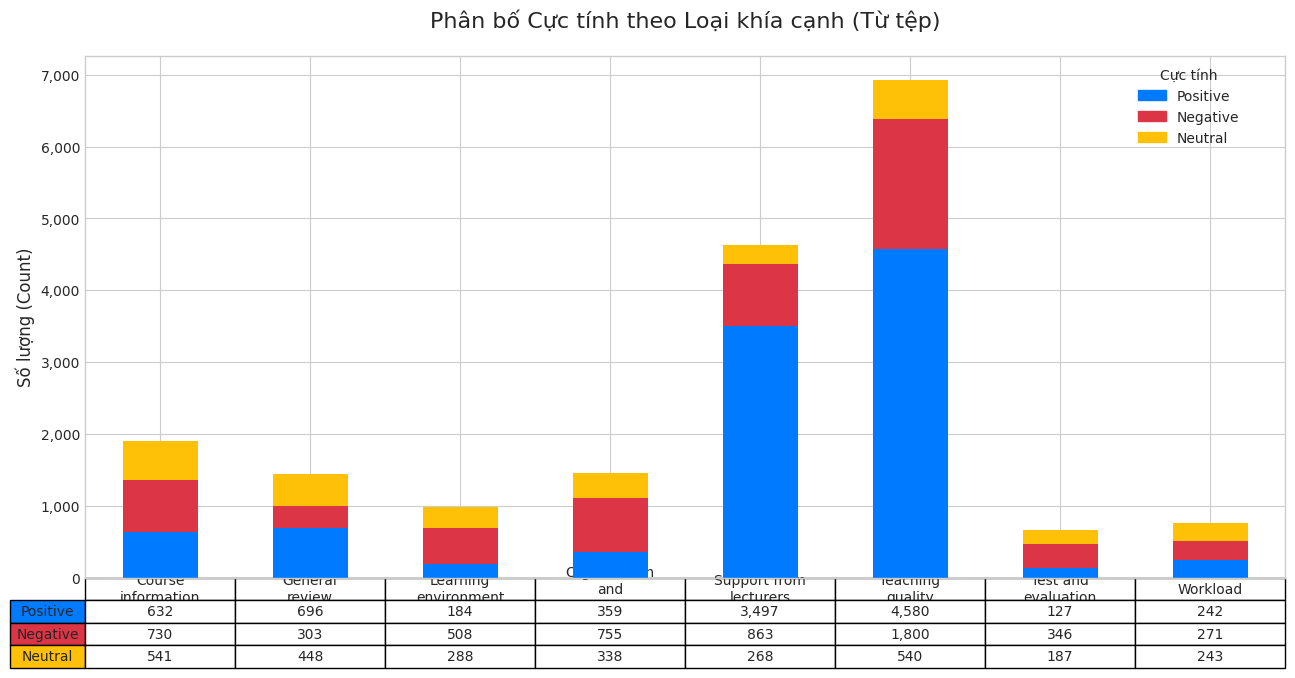

--- HOÀN THÀNH ---


In [12]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import traceback
import io
import textwrap # Import thư viện textwrap

# --- 1. Read and Parse Data from File ---
file_path = "output_semeval_format_v3_no_overlap.txt"
aspects_data = []
data_json = None

try:
    print(f"Đang đọc tệp: {file_path}")
    with open(file_path, 'r', encoding='utf-8') as f:
        file_content = f.read()
        data_json = json.loads(file_content)
    print("Đọc và phân tích JSON thành công.")

    # --- 2. Extract Aspects ---
    print("Đang trích xuất dữ liệu khía cạnh...")
    if 'sentences' in data_json and 'sentence' in data_json['sentences']:
        sentence_list = data_json['sentences']['sentence']
        if not isinstance(sentence_list, list):
            sentence_list = [sentence_list]

        for sentence in sentence_list:
            if 'aspects' in sentence and sentence['aspects']:
                aspect_list = sentence['aspects']
                if not isinstance(aspect_list, list):
                    if isinstance(aspect_list, dict):
                         aspect_list = [aspect_list]
                    else:
                        continue

                for aspect in aspect_list:
                     if isinstance(aspect, dict) and 'category' in aspect and 'polarity' in aspect:
                        aspects_data.append({
                            'category': aspect['category'],
                            'polarity': aspect['polarity']
                        })
                     else:
                        continue
    else:
        print("Cấu trúc JSON không chứa 'sentences/sentence' như mong đợi.")


except FileNotFoundError:
    print(f"LỖI: Không tìm thấy tệp '{file_path}'. Vui lòng đảm bảo tệp đã được tải lên và tên chính xác.")
    aspects_data = None
except json.JSONDecodeError as e:
    print(f"LỖI: Không thể phân tích cú pháp JSON từ tệp. Định dạng tệp có thể bị lỗi.")
    print(f"Chi tiết lỗi: {e}")
    print(f"Lỗi xảy ra gần dòng {e.lineno}, cột {e.colno}")
    aspects_data = None
except Exception as e:
    print(f"LỖI: Đã xảy ra lỗi không mong muốn khi đọc hoặc xử lý tệp.")
    print(traceback.format_exc())
    aspects_data = None

# --- Proceed only if data extraction was successful ---
if aspects_data is not None:
    if not aspects_data:
        print("Không tìm thấy dữ liệu khía cạnh nào hợp lệ trong tệp để vẽ biểu đồ.")
    else:
        print(f"Đã trích xuất thành công {len(aspects_data)} khía cạnh.")
        # --- 3. Create DataFrame and Calculate Counts ---
        df_from_file = pd.DataFrame(aspects_data)
        print("Đã tạo DataFrame từ dữ liệu khía cạnh.")

        print("Đang đếm số lượng cực tính theo loại khía cạnh...")
        df = pd.crosstab(df_from_file['category'], df_from_file['polarity'])
        print("Hoàn thành đếm.")

        polarity_order = ['positive', 'negative', 'neutral']

        existing_polarities = [p for p in polarity_order if p in df.columns]
        missing_polarities = [p for p in polarity_order if p not in df.columns]
        df = df.reindex(columns=existing_polarities, fill_value=0)
        for p in missing_polarities:
            df[p] = 0
        df = df[polarity_order]

        df = df.sort_index()
        print("DataFrame đã được chuẩn bị để vẽ:")
        print(df.head())

        category_order = df.index.tolist()
        num_categories = len(category_order)
        print(f"Số lượng category: {num_categories}")

        # --- 4. Plotting ---
        print("Bắt đầu vẽ biểu đồ...")
        plt.style.use('seaborn-v0_8-whitegrid')
        colors = ['#007bff', '#dc3545', '#ffc107']

        # Giữ nguyên cách tính chiều rộng, chiều cao có thể cần điều chỉnh sau
        figure_width = max(16, num_categories * 1.3)
        figure_height = 9 # Bắt đầu với chiều cao 9 inches
        print(f"Tính toán kích thước biểu đồ (width, height): ({figure_width}, {figure_height})")
        fig, ax = plt.subplots(figsize=(figure_width, figure_height))

        df.plot(kind='bar', stacked=True, color=colors, ax=ax, legend=False)
        print("Đã vẽ biểu đồ cột.")

        # --- 5. Customize Chart ---
        ax.set_title('Phân bố Cực tính theo Loại khía cạnh (Từ tệp)', fontsize=16, pad=20)
        ax.set_xlabel('', fontsize=12)
        ax.set_ylabel('Số lượng (Count)', fontsize=12)
        formatter = mticker.FuncFormatter(lambda x, p: format(int(x), ','))
        ax.yaxis.set_major_formatter(formatter)
        ax.set_ylim(bottom=0)
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        # --- 6. Prepare and Add Table ---
        print("Chuẩn bị và thêm bảng dữ liệu...")
        df_table = df.T
        df_table = df_table.reindex(index=polarity_order, fill_value=0)

        cell_text_formatted = []
        for row_idx in range(len(df_table)):
            formatted_row = [f"{int(x):,}" for x in df_table.iloc[row_idx]]
            cell_text_formatted.append(formatted_row)

        row_labels = [p.capitalize() for p in df_table.index]

        # === XỬ LÝ WORD WRAP CHO NHÃN CỘT ===
        print("Đang xử lý word wrap cho nhãn cột...")
        # Đặt chiều rộng tối đa mong muốn cho mỗi dòng (số ký tự)
        # Bạn có thể điều chỉnh giá trị `wrap_width` này
        wrap_width = 12
        wrapped_col_labels = [textwrap.fill(label, width=wrap_width) for label in df_table.columns]
        print("Đã xử lý word wrap.")
        # ===================================

        # Add table with wrapped column labels
        the_table = ax.table(cellText=cell_text_formatted,
                             rowLabels=row_labels,
                             rowColours=colors,
                             colLabels=wrapped_col_labels, # Sử dụng nhãn đã wrap
                             loc='bottom',
                             cellLoc='center',
                             rowLoc='center',
                             colLoc='center') # Giữ căn giữa cho cột
        print("Đã thêm bảng.")

        # Customize table appearance
        the_table.auto_set_font_size(False)
        the_table.set_fontsize(10)
        # Điều chỉnh tỷ lệ scale, đặc biệt là chiều cao (thứ 2) nếu cần
        # Có thể không cần scale nhiều nếu word wrap hoạt động tốt
        the_table.scale(1, 1.8) # Tăng chiều cao ô để chứa text wrap

        # === BỎ PHẦN XOAY NHÃN ===
        # (Đoạn code xoay nhãn đã bị xóa)

        # Adjust layout - Điều chỉnh bottom margin để có đủ chỗ cho bảng có thể cao hơn do wrap
        # Có thể cần giá trị bottom lớn hơn một chút so với mặc định
        right_margin = 0.9 if figure_width > 25 else 0.85
        plt.subplots_adjust(left=0.1, bottom=0.3, right=right_margin) # Thử bottom=0.3

        # --- 7. Add Legend ---
        legend_labels = [p.capitalize() for p in polarity_order]
        handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(polarity_order))]
        legend_bbox_x = 1.02 / (1/right_margin) if right_margin < 1 else 1.02
        ax.legend(handles, legend_labels, title='Cực tính', bbox_to_anchor=(legend_bbox_x, 1), loc='upper left')

        print("Đã thêm chú giải.")

        # --- 8. Save and Show ---
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        print("Đã lưu biểu đồ vào buffer.")
        plt.close(fig)

        from IPython.display import display, Image
        print("\n--- BIỂU ĐỒ ---")
        display(Image(buf.getvalue()))
        print("--- HOÀN THÀNH ---")

if aspects_data is None:
    print("\nKhông thể tạo biểu đồ do lỗi khi đọc hoặc xử lý tệp.")
elif not aspects_data:
     print("\nKhông thể tạo biểu đồ do không có dữ liệu khía cạnh hợp lệ.")